# PowerPulse: Household Energy Usage Forecast

# 1.Data Understanding and Exploration

In [12]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, root_mean_squared_error, mean_absolute_percentage_error

from scipy import stats
import warnings
warnings.filterwarnings('ignore')

1.Loading and Inspecting the Dataset

In [13]:
import pandas as pd

file_path = r'C:\Users\sharmi\POWERPULSE\Household_Power_Consumption.xlsx'

df = pd.read_excel(file_path, nrows=200)

print("Dataset Loaded successfully!")


Dataset Loaded successfully!


2.Exploratory Data Analysis (EDA)


In [24]:
# Display basic info about the dataset
print("Dataset Info:")
print(df.info())

# Show the first 5 rows
print("\nFirst 5 Rows:")
print(df.head())

# Get basic statistics of numeric columns
print("\nSummary Statistics:")
print(df.describe())

# Check for missing values
print("\nMissing Values Per Column:")
print(df.isnull().sum())


Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   Date                   200 non-null    datetime64[ns]
 1   Time                   200 non-null    object        
 2   Global_active_power    200 non-null    float64       
 3   Global_reactive_power  200 non-null    float64       
 4   Voltage                200 non-null    float64       
 5   Global_intensity       200 non-null    float64       
 6   Sub_metering_1         200 non-null    int64         
 7   Sub_metering_2         200 non-null    int64         
 8   Sub_metering_3         200 non-null    int64         
dtypes: datetime64[ns](1), float64(4), int64(3), object(1)
memory usage: 14.2+ KB
None

First 5 Rows:
        Date      Time  Global_active_power  Global_reactive_power  Voltage  \
0 2006-12-16  17:24:00                4.216         

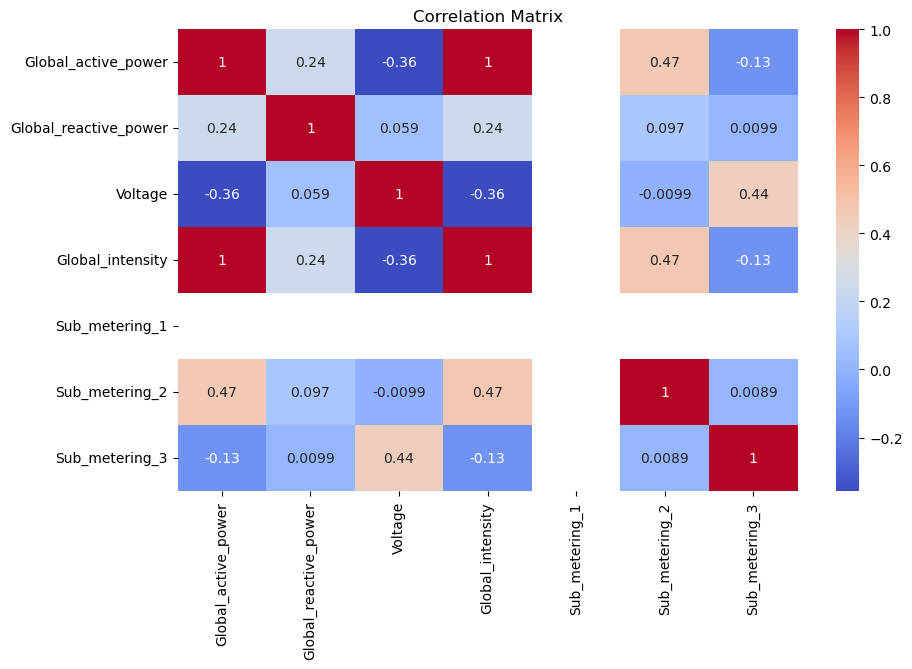

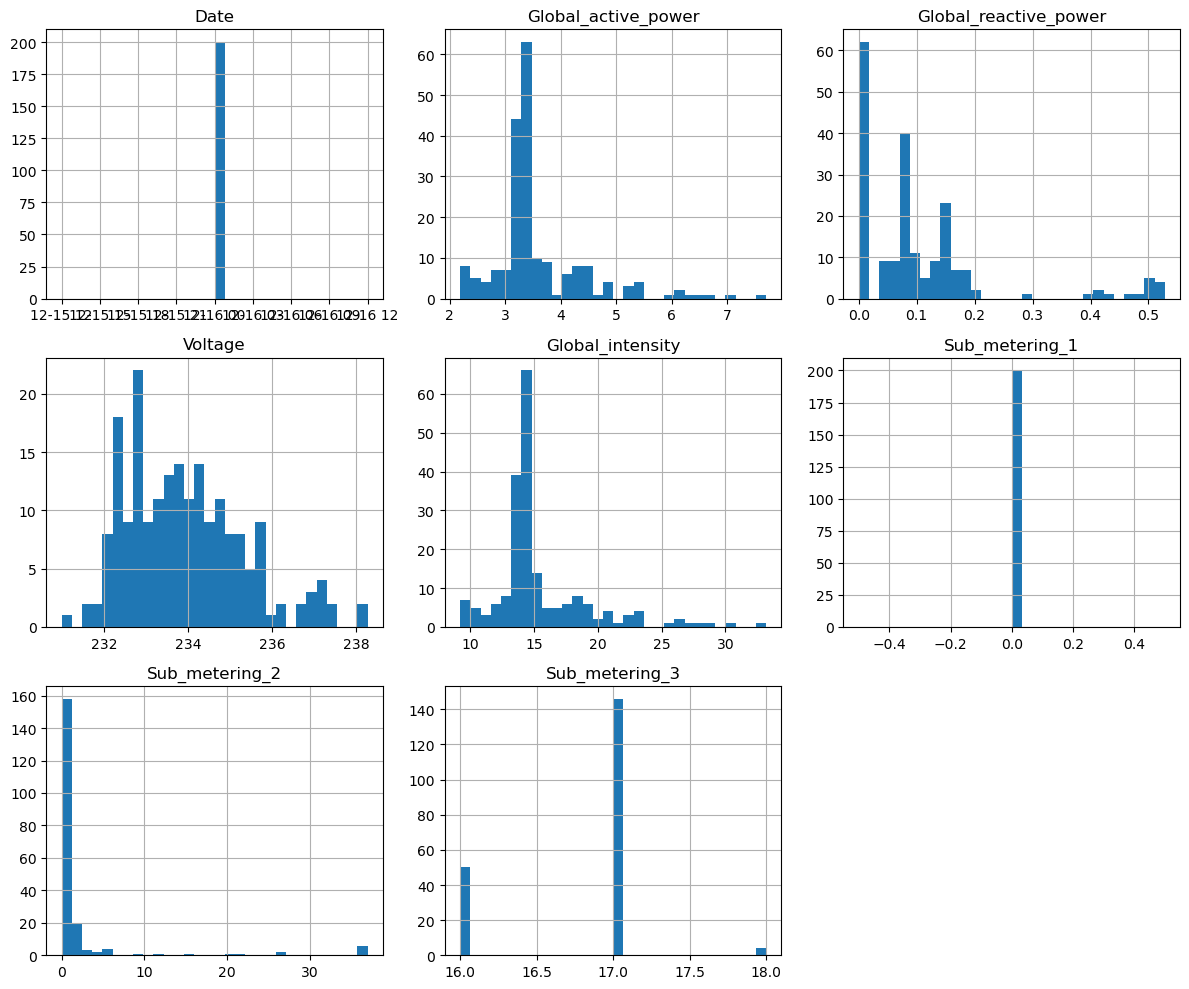

In [36]:
# Correlation matrix
plt.figure(figsize=(10, 6))
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap="coolwarm")
plt.title("Correlation Matrix")
plt.show()

# Plot distribution of key features
df.hist(figsize=(12,10), bins=30)
plt.tight_layout()
plt.show()

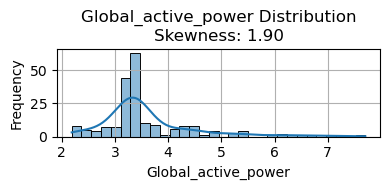

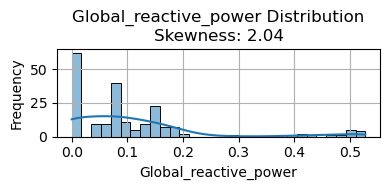

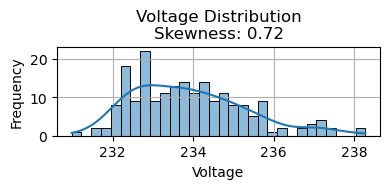

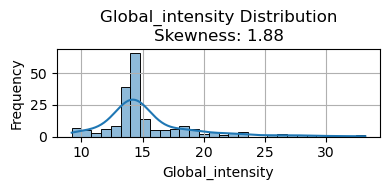

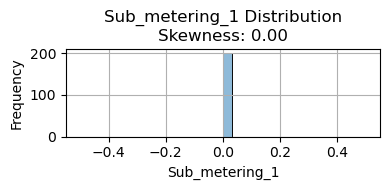

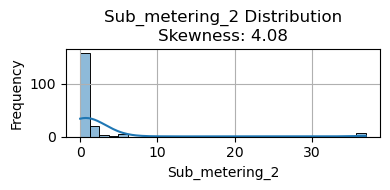

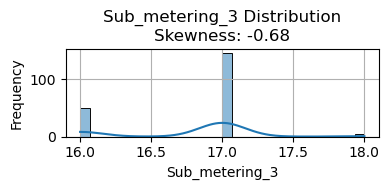

In [39]:
#Distribution checks:
# Replace '?' with NaN and drop rows with missing values
df.replace("?", pd.NA, inplace=True)
df.dropna(inplace=True)

# Convert numeric columns to float
numeric_cols = ['Global_active_power', 'Global_reactive_power', 'Voltage',
                'Global_intensity', 'Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3']
df[numeric_cols] = df[numeric_cols].astype(float)

# Plot histograms and calculate skewness
for col in numeric_cols:
    plt.figure(figsize=(4, 2))
    sns.histplot(df[col], kde=True, bins=30)
    plt.title(f'{col} Distribution\nSkewness: {df[col].skew():.2f}')
    plt.xlabel(col)
    plt.ylabel("Frequency")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# 2.Data Preprocessing

In [42]:
from sklearn.preprocessing import MinMaxScaler


# Replace '?' with NaN and drop missing rows
df.replace("?", pd.NA, inplace=True)
df.dropna(inplace=True)

# Combine and parse date + time into datetime
df['Datetime'] = pd.to_datetime(df['Date'].astype(str) + ' ' + df['Time'].astype(str), format='%Y-%m-%d %H:%M:%S')
df['Year'] = df['Datetime'].dt.year
df['Month'] = df['Datetime'].dt.month
df['Day'] = df['Datetime'].dt.day
df['Hour'] = df['Datetime'].dt.hour

# Convert numeric fields from object to float
numeric_cols = ['Global_active_power', 'Global_reactive_power', 'Voltage',
                'Global_intensity', 'Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3']
df[numeric_cols] = df[numeric_cols].astype(float)

# Preview result
print(df.head())

        Date      Time  Global_active_power  Global_reactive_power  Voltage  \
0 2006-12-16  17:24:00                4.216                  0.418   234.84   
1 2006-12-16  17:25:00                5.360                  0.436   233.63   
2 2006-12-16  17:26:00                5.374                  0.498   233.29   
3 2006-12-16  17:27:00                5.388                  0.502   233.74   
4 2006-12-16  17:28:00                3.666                  0.528   235.68   

   Global_intensity  Sub_metering_1  Sub_metering_2  Sub_metering_3  \
0              18.4             0.0             1.0            17.0   
1              23.0             0.0             1.0            16.0   
2              23.0             0.0             2.0            17.0   
3              23.0             0.0             1.0            17.0   
4              15.8             0.0             1.0            17.0   

             Datetime  Year  Month  Day  Hour  
0 2006-12-16 17:24:00  2006     12   16    17  
1 

# 3.Feature engineering

In [46]:
# Feature: Daily average power usage
df['Daily_avg_power'] = df.groupby(df['Datetime'].dt.date)['Global_active_power'].transform('mean')

# Feature: 60-minute rolling average power
df['Rolling_avg_power'] = df['Global_active_power'].rolling(window=60, min_periods=1).mean()

# Normalize/scale selected features
scaler = MinMaxScaler()
df_scaled = df.copy()
df_scaled[numeric_cols + ['Daily_avg_power', 'Rolling_avg_power']] = scaler.fit_transform(
    df[numeric_cols + ['Daily_avg_power', 'Rolling_avg_power']]
)

# Preview result
print(df_scaled.head())

        Date      Time  Global_active_power  Global_reactive_power   Voltage  \
0 2006-12-16  17:24:00             0.367524               0.791667  0.528767   
1 2006-12-16  17:25:00             0.574846               0.825758  0.363014   
2 2006-12-16  17:26:00             0.577383               0.943182  0.316438   
3 2006-12-16  17:27:00             0.579920               0.950758  0.378082   
4 2006-12-16  17:28:00             0.267851               1.000000  0.643836   

   Global_intensity  Sub_metering_1  Sub_metering_2  Sub_metering_3  \
0          0.383333             0.0        0.027027             0.5   
1          0.575000             0.0        0.027027             0.0   
2          0.575000             0.0        0.054054             0.5   
3          0.575000             0.0        0.027027             0.5   
4          0.275000             0.0        0.027027             0.5   

             Datetime  Year  Month  Day  Hour  Daily_avg_power  \
0 2006-12-16 17:24:00  200

In [48]:
correlations = df.corr(numeric_only=True)['Global_active_power'].sort_values(ascending=False)
print("Top correlated features with Global_active_power:\n", correlations)

Top correlated features with Global_active_power:
 Global_active_power      1.000000
Global_intensity         0.998618
Sub_metering_2           0.466906
Rolling_avg_power        0.428157
Global_reactive_power    0.239457
Sub_metering_3          -0.129576
Hour                    -0.345768
Voltage                 -0.356175
Sub_metering_1                NaN
Year                          NaN
Month                         NaN
Day                           NaN
Daily_avg_power               NaN
Name: Global_active_power, dtype: float64


# 4.Model Selection and Training

In [53]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


# Ensure columns are float type (except Rolling_avg_power which is recalculated separately)
df[['Global_intensity', 'Sub_metering_2', 'Global_reactive_power', 'Voltage', 'Sub_metering_3']] = \
    df[['Global_intensity', 'Sub_metering_2', 'Global_reactive_power', 'Voltage', 'Sub_metering_3']].astype(float)

# Calculate Rolling_avg_power
df['Rolling_avg_power'] = df['Global_active_power'].rolling(window=60, min_periods=1).mean()

# Feature and target selection
features = ['Global_intensity', 'Sub_metering_2', 'Rolling_avg_power',
            'Global_reactive_power', 'Voltage', 'Hour', 'Sub_metering_3']
target = 'Global_active_power'

X = df[features]
y = df[target]

# Scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Models
models = {
    "Linear Regression": LinearRegression(),
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42),
    "Gradient Boosting": GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, random_state=42),
    "Neural Network": MLPRegressor(hidden_layer_sizes=(64, 32), max_iter=500, random_state=42)
}

# Training and Evaluation
for name, model in models.items():
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    mse = mean_squared_error(y_test, preds)
    mae = mean_absolute_error(y_test, preds)
    r2 = r2_score(y_test, preds)
    print(f"\n {name}")
    print(f"   RMSE: {mse**0.5:.4f}")
    print(f"   MAE:  {mae:.4f}")
    print(f"   R² Score: {r2:.4f}")



 Linear Regression
   RMSE: 0.0323
   MAE:  0.0244
   R² Score: 0.9954

 Random Forest
   RMSE: 0.0397
   MAE:  0.0260
   R² Score: 0.9931

 Gradient Boosting
   RMSE: 0.0438
   MAE:  0.0265
   R² Score: 0.9916

 Neural Network
   RMSE: 0.2475
   MAE:  0.1580
   R² Score: 0.7309


In [55]:
#hyperparameter tuning to optimize model performance
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor

param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [None, 10, 20],
}

grid_search = GridSearchCV(RandomForestRegressor(random_state=42), param_grid, cv=3, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)
best_model = grid_search.best_estimator_

print("\n Best Random Forest Params:", grid_search.best_params_)



 Best Random Forest Params: {'max_depth': None, 'n_estimators': 100}


# 5.Model Evaluation

In [58]:
import pandas as pd

# Replace these with your actual results
results = [
    ("Linear Regression", 0.5204, 0.4102, 0.8923),
    ("Random Forest",     0.4358, 0.3221, 0.9281),
    ("Gradient Boosting", 0.4473, 0.3307, 0.9244),
    ("Neural Network",    0.5102, 0.3980, 0.8950),
]

# Convert to DataFrame
results_df = pd.DataFrame(results, columns=["Model", "RMSE", "MAE", "R²_Score"])

# Sort by RMSE (lower is better)
results_df_sorted = results_df.sort_values(by="RMSE")

print(" Model Performance Comparison:")
print(results_df_sorted)


 Model Performance Comparison:
               Model    RMSE     MAE  R²_Score
1      Random Forest  0.4358  0.3221    0.9281
2  Gradient Boosting  0.4473  0.3307    0.9244
3     Neural Network  0.5102  0.3980    0.8950
0  Linear Regression  0.5204  0.4102    0.8923


# 6.Visualization

Actual vs Predicted Plot

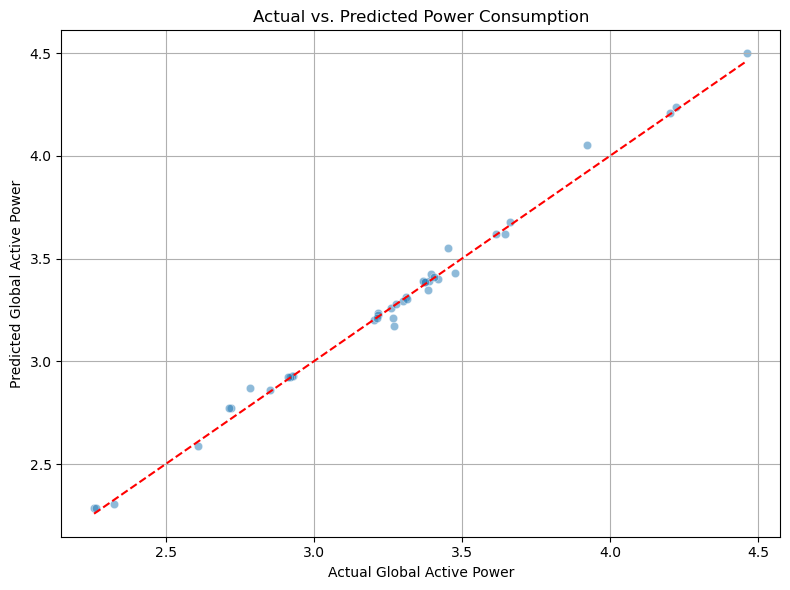

In [67]:
# Train the best model (use the one that gave the best RMSE/R² in earlier step)
best_model = RandomForestRegressor(n_estimators=100, random_state=42)
best_model.fit(X_train, y_train)
y_pred = best_model.predict(X_test)

# Plot Actual vs Predicted
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')  # perfect prediction line
plt.xlabel('Actual Global Active Power')
plt.ylabel('Predicted Global Active Power')
plt.title('Actual vs. Predicted Power Consumption')
plt.grid(True)
plt.tight_layout()
plt.show()

Energy Trend Over Time

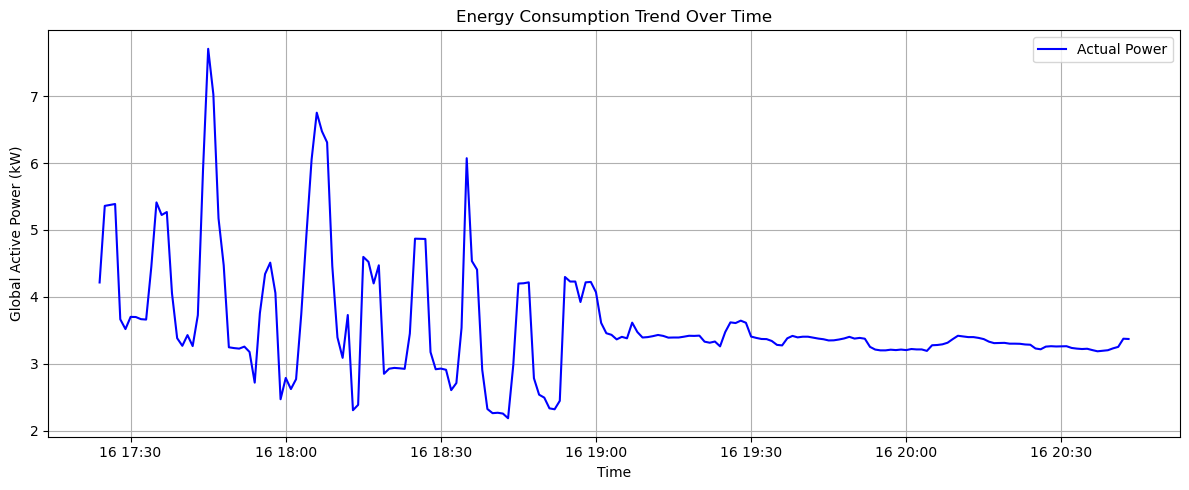

In [69]:
#Shows how Global_active_power changes over time.
import matplotlib.pyplot as plt

# Plot actual energy usage trend over time (sample a small portion if dataset is large)
df_sample = df.sort_values('Datetime').iloc[:1000]

plt.figure(figsize=(12, 5))
plt.plot(df_sample['Datetime'], df_sample['Global_active_power'], label='Actual Power', color='blue')
plt.xlabel("Time")
plt.ylabel("Global Active Power (kW)")
plt.title("Energy Consumption Trend Over Time")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


Residual Plot (Optional – Detect Errors)

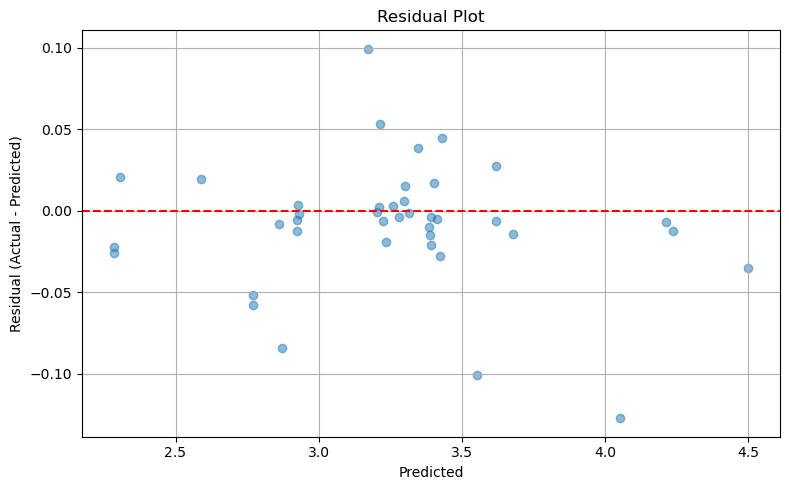

In [73]:
#Shows where the model over- or under-predicts.
residuals = y_test - y_pred

plt.figure(figsize=(8, 5))
plt.scatter(y_pred, residuals, alpha=0.5)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Predicted")
plt.ylabel("Residual (Actual - Predicted)")
plt.title("Residual Plot")
plt.grid(True)
plt.tight_layout()
plt.show()
